Ноутбук был создан напрямую в соревновании каггл, в каггл ноутбуке, поэтому тут есть отличия от коллаба, а также возникают предупреждения, которые в коллабе бы не появились при данном же коде (на работу предупреждения вроде как не влияют), просто в каггл ноутбуке быстрее грузятся датасеты.

In [1]:
import os
import numpy as np 
import pandas as pd 
import shutil
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

2024-06-20 00:18:05.339092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 00:18:05.339229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 00:18:05.617405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [4]:
train_zip_path = '/kaggle/input/dogs-vs-cats/train.zip'
test_zip_path = '/kaggle/input/dogs-vs-cats/test1.zip'

# Распаковка архивов
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

In [5]:
# Путь
train_dir = '/kaggle/working/train/'

# Создание директорий для кошек и собак
os.makedirs(os.path.join(train_dir, 'cat'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'dog'), exist_ok=True)

# Переместим фотографии в директории для кошек и собак
for filename in os.listdir(train_dir):
    src = os.path.join(train_dir, filename)
    if os.path.isfile(src):
        if 'cat' in filename:
            shutil.move(src, os.path.join(train_dir, 'cat', filename))
        elif 'dog' in filename:
            shutil.move(src, os.path.join(train_dir, 'dog', filename))


In [6]:
# Подготовим данные для обучающей и валидационной выборки
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
# В качесте модели возьмем готовую ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Обучение модели
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.4922 - loss: 0.8060   

I0000 00:00:1718842778.034575     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718842778.075969     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9691 - loss: 0.0813

W0000 00:00:1718842822.030098     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - accuracy: 0.9691 - loss: 0.0813 - val_accuracy: 0.9836 - val_loss: 0.0458
Epoch 2/5


W0000 00:00:1718842838.032492     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9907 - loss: 0.0248 - val_accuracy: 0.9830 - val_loss: 0.0420
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9956 - loss: 0.0144 - val_accuracy: 0.9842 - val_loss: 0.0447
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9972 - loss: 0.0105 - val_accuracy: 0.9844 - val_loss: 0.0447
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9993 - loss: 0.0060 - val_accuracy: 0.9826 - val_loss: 0.0510


In [9]:
# Оценка модели
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9819 - loss: 0.0572
Test accuracy: 0.9825999736785889


In [10]:
# Подготовка данных для тестирования
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/',
    classes=['test1'],
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Предсказания на тестовых данных
predictions = model.predict(test_generator)

# подготовка меток
predicted_classes = (predictions > 0.5).astype(int)
labels = {0: 'cat', 1: 'dog'}
predicted_labels = [labels[cls[0]] for cls in predicted_classes]


Found 12500 images belonging to 1 classes.
  3/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step

W0000 00:00:1718843090.276841     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step


W0000 00:00:1718843124.721974     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


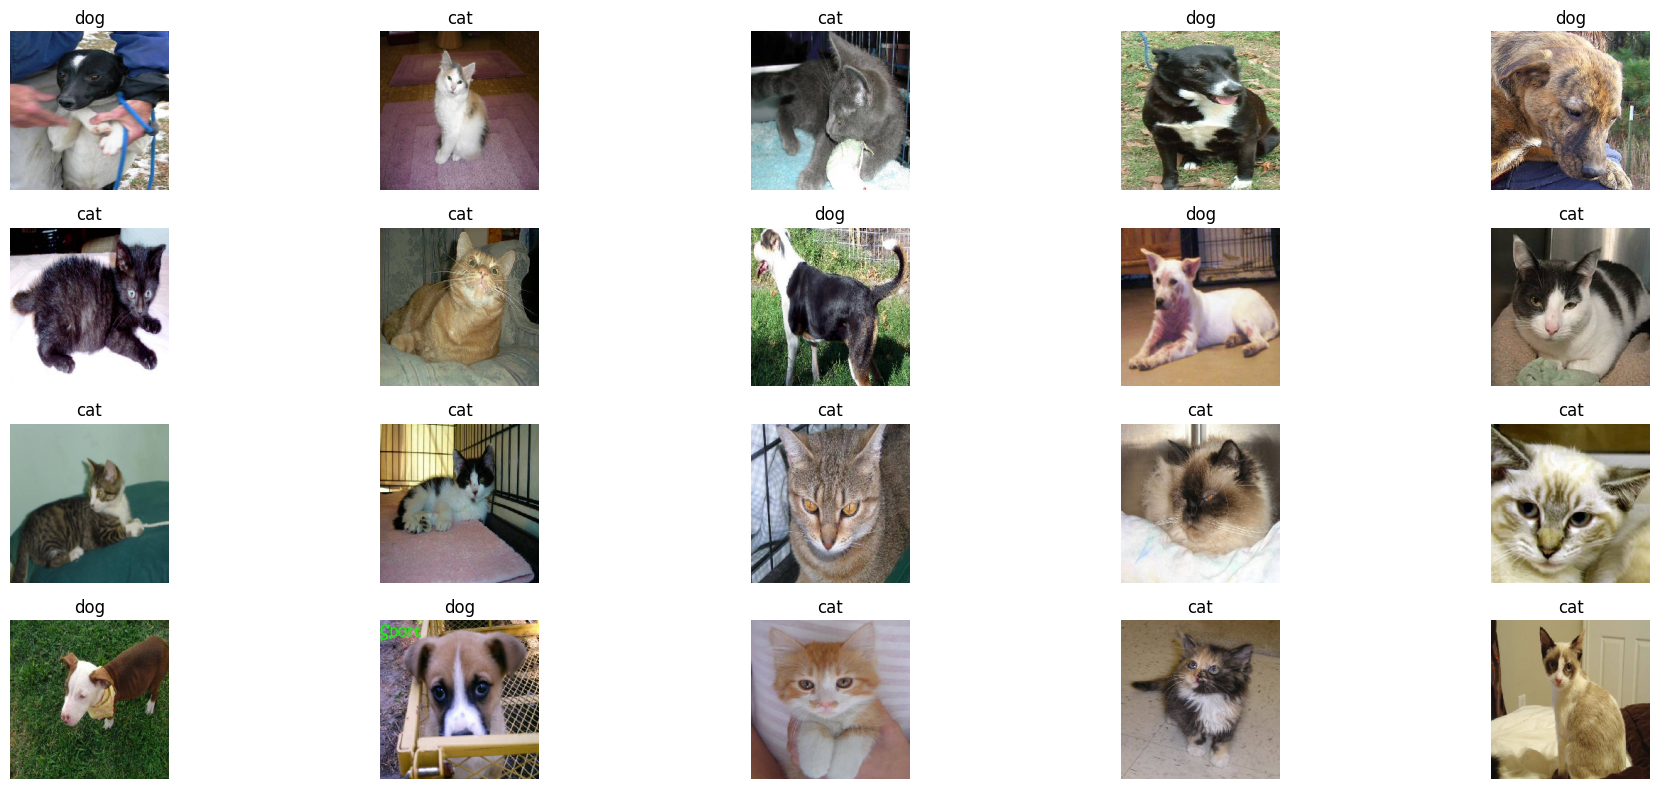

In [11]:
# Выведем первые 20 предсказаний вместе с изображениями
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    img = image.load_img(test_generator.filepaths[i], target_size=(224, 224))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(predicted_labels[i])

plt.tight_layout()
plt.show()